In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

В этом ноутбуке предлагается обучить модель классификации изображений датасета CIFAR10, который содержит 60к цветных картинок разрешения 32х32 принадлежащих 10 классам.


Я изучал книгу Программируем с PyTorch (Пойнтер Ян) и оттуда взял код
Я для решения испольовал принцип перенос обучения на модели resnet50 (обучал только последний польносвязанный слой)



Загрузим датасет

In [7]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 512

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)



testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),  shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Отрисуем несколько картинок, посмотрим, как выглядит наш датасет



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


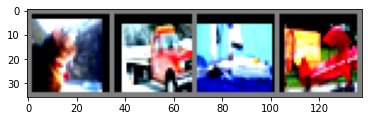

  cat truck  ship plane


In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Определяем устроство:

In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='cpu')

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Функция обучения: (она идетинтична для всех моделей)

In [14]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=3, device="cpu"):
    model.train()
    for epoch in tqdm(range(epochs + 1)):
        for batch in train_loader:
            optimizer.zero_grad()

            inputs, targets = batch

            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)

            loss = loss_fn(output, targets)

            loss.backward()
            optimizer.step()

    model.eval()
    for batch in val_loader:
        inputs, targets = batch

        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)

        true_lab = targets.numpy()

        _, preds = torch.max(output, dim=1)
        print('accuracy_score: ', accuracy_score(true_lab, preds.detach().cpu().numpy()))


Сделаем простую модель на сверточных слоях с несколькими полносвязными слоями в конце.


In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size = 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.Tanh()(self.conv1(x)))
        x = self.pool(nn.Tanh()(self.conv2(x)))
        x = nn.Flatten()(x)
        x = nn.Tanh()(self.fc1(x))
        x = nn.Tanh()(self.fc2(x))
        x = nn.Softmax()(self.fc3(x))
        return x


net = Net()

Закинем модель на ГПУ. Выберем в качестве лосс-функции кросс-энтропию. В качестве оптимизатора возьмем Адам.

In [16]:
net = Net()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
train(net, optimizer, torch.nn.CrossEntropyLoss(), trainloader, testloader, epochs=5, device=device)


100%|██████████| 5/5 [02:13<00:00, 26.63s/it]


accuracy_score:  0.4977


Обучим модель более сложную
 - функция активации ReLU
 - несколько слоев Conv2d + ReLU + MaxPool2d
 - усреденение блоков выше
 - полносвязанный слой
 

In [20]:
class CNNNet(nn.Module):

    def __init__(self, num_classes=10):

        super(CNNNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
cnnnet = CNNNet()
cnnnet.to(device)
optimizer = optim.Adam(cnnnet.parameters(), lr=0.001)

train(cnnnet, optimizer, torch.nn.CrossEntropyLoss(), trainloader, testloader, epochs=5, device=device)


  0%|          | 0/5 [00:00<?, ?it/s]

перенос обучения  - модель resnet50 (уже обученная), обучаем только последний полносвязанный слой

In [ ]:
transfer_model = models.resnet50(pretrained=True)
for name, param in transfer_model.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

transfer_model.fc = nn.Sequential(
    nn.Linear(transfer_model.fc.in_features,500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500,10)
)

In [ ]:
transfer_model.to(device)
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)
train(transfer_model, optimizer, torch.nn.CrossEntropyLoss(), trainloader, testloader, epochs=5, device=device)